In [1]:
import json
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

In [2]:
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('All_Beauty.json.gz')

In [3]:
print('Dataset size: {:,} words'.format(len(df)))

Dataset size: 371,345 words


In [4]:
print(df['asin'].value_counts())

B000FOI48G    8672
B000GLRREU    8341
1620213982    4792
B001QY8QXM    4544
B01DKQAXC0    4246
              ... 
B01FV4FHO8       1
B00INVFWZG       1
B00AZSWPTG       1
B00IQ2OCF8       1
B00GLP4W6G       1
Name: asin, Length: 32586, dtype: int64


* B000FOI48G: Waterpik Ultra Water Flosser
https://www.amazon.com/dp/B000FOI48G
* B0043OYFKU : Olay Pro-X Advanced Cleansing System + 20 ml Renewal Cleanser, Packaging May Vary
https://www.amazon.com/dp/B0043OYFKU
* B01DKQAXC0 : BALI SECRETS All Natural Deodorant for Women & Men. Organic & Vegan. Pure Ingredients. All Day Protection. 2.5 fl oz [Scent: Sandalwood]
https://www.amazon.com/dp/B01DKQAXC0

In [5]:
import sys
import re, string
import numpy as np
import wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet

In [6]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [7]:
#select reviews of Waterpik flosser 
data = df[df['asin'] == 'B000FOI48G']
data = data[data['verified'] == True]
#df = df[(df['year'] == '2018')]

data.head()
#def getResults(asinID):
#    data = df[df['asin'] == asinID]

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
127498,5.0,True,"06 17, 2018",A39VRTC4O3SHQH,B000FOI48G,Oscar alphie,did its job as promoted,Five Stars,1529193600,NaN,NaN,NaN
127499,4.0,True,"06 13, 2018",A2MSPS4AH6PGRZ,B000FOI48G,Dave Iwai,"I'm using tap water for drinking and cooking, ...",but water tastes much better since I started t...,1528848000,NaN,NaN,NaN
127500,1.0,True,"06 13, 2018",A3DEXGW9WP20WL,B000FOI48G,Llini Ugaz,This was defective and we returned it. But we ...,This was defective and we returned it. But we ...,1528848000,NaN,NaN,NaN
127501,5.0,True,"06 12, 2018",A2XYWXKDCYSYKQ,B000FOI48G,Amazon Customer,A+++,Five Stars,1528761600,NaN,NaN,NaN
127502,5.0,True,"06 12, 2018",A51H3TJMN67TK,B000FOI48G,Gloria,good product,Five Stars,1528761600,NaN,NaN,NaN


In [8]:
reviews = data['reviewText']
#reviews.count()

In [9]:
stop_words = stopwords.words('english')
reviews = reviews.dropna()
reviews.isnull().values.any()
reviews = reviews.tolist()
type(reviews)
data.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
127498,5.0,True,"06 17, 2018",A39VRTC4O3SHQH,B000FOI48G,Oscar alphie,did its job as promoted,Five Stars,1529193600,NaN,NaN,NaN
127499,4.0,True,"06 13, 2018",A2MSPS4AH6PGRZ,B000FOI48G,Dave Iwai,"I'm using tap water for drinking and cooking, ...",but water tastes much better since I started t...,1528848000,NaN,NaN,NaN
127500,1.0,True,"06 13, 2018",A3DEXGW9WP20WL,B000FOI48G,Llini Ugaz,This was defective and we returned it. But we ...,This was defective and we returned it. But we ...,1528848000,NaN,NaN,NaN
127501,5.0,True,"06 12, 2018",A2XYWXKDCYSYKQ,B000FOI48G,Amazon Customer,A+++,Five Stars,1528761600,NaN,NaN,NaN
127502,5.0,True,"06 12, 2018",A51H3TJMN67TK,B000FOI48G,Gloria,good product,Five Stars,1528761600,NaN,NaN,NaN


In [10]:
from nltk.stem.wordnet import WordNetLemmatizer

In [11]:
wordnet_lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'[a-z]+')

def preProcess(document):
    document = document.lower()
    words = tokenizer.tokenize(document)
    words = [w for w in words if not w in stop_words]
    # Lemmatizing
    for pos in [wordnet.NOUN, wordnet.VERB, wordnet.ADJ, wordnet.ADV]:
        words = [wordnet_lemmatizer.lemmatize(x, pos) for x in words]
    return " ".join(words)

In [12]:
data_processed = data['reviewText'].astype(str).apply(preProcess)

# spilt data into three category by overall rating
pos = data[data['overall']>3]
neu = data[data['overall']==3]
neg =  data[data['overall']<3]
#pos.head(),neg.head()

In [13]:
len(pos),len(neu),len(neg)

(6714, 474, 523)

In [14]:
# process the reviews 
pos_processed =pos['reviewText'].astype(str).apply(preProcess)
neg_processed =neg['reviewText'].astype(str).apply(preProcess)
data_processed = data['reviewText'].astype(str).apply(preProcess)

(-0.5, 599.5, 429.5, -0.5)

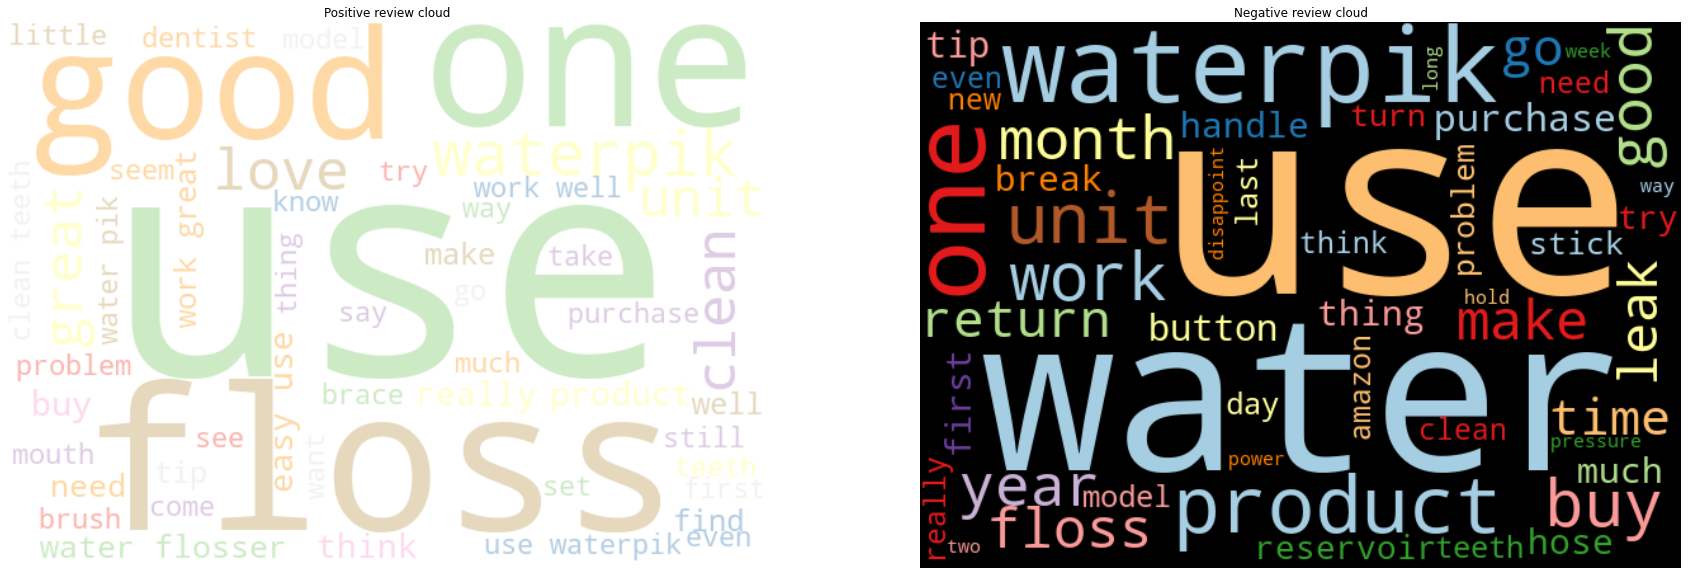

In [15]:
#plot word cloud fpr positive and negative
plt.figure(figsize=(30,15))
plt.subplot(121)
wordcloud1  = wordcloud.WordCloud(colormap = 'Pastel1',background_color='white'
                            ,width=600, height=430, max_words=50).generate(' '.join(pos_processed))
plt.imshow(wordcloud1, interpolation="bilinear")
plt.title("Positive review cloud")
plt.axis("off")
plt.subplot(122)
wordcloud2  = wordcloud.WordCloud(colormap = 'Paired',background_color='black'
                            ,width=600, height=430, max_words=50).generate(' '.join(neg_processed))
plt.imshow(wordcloud2, interpolation="bilinear")
plt.title("Negative review cloud")
plt.axis("off")

(-0.5, 599.5, 429.5, -0.5)

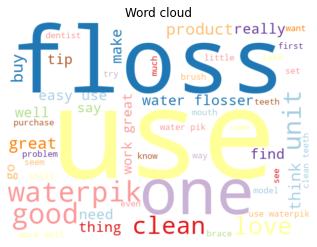

In [16]:
#word cloud for all reviews 
wordcloud  = wordcloud.WordCloud(colormap = 'Paired',background_color='white'
                            ,width=600, height=430, max_words=50).generate(' '.join(data_processed))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Word cloud")
plt.axis("off")

In [17]:
pos_processed.str.split(expand=True).stack().value_counts()

use           5915
water         3512
floss         2825
teeth         2792
clean         2648
              ... 
freind           1
waterproof       1
puncture         1
afire            1
pd               1
Length: 6307, dtype: int64

In [18]:
neg_processed.str.split(expand=True).stack().value_counts()

water        443
use          405
work         260
waterpik     251
one          246
            ... 
unravel        1
fun            1
pardon         1
resort         1
variation      1
Length: 2285, dtype: int64